# Building up tools to compute an approximation of the 2-Wasserstein distance

> In this section we create a function to compute an approximation of the 2-Wasserstein distance between two univariate data sets

In [1]:
from dolfin import *
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statFEM_analysis.oneDim import mean_assembler, kernMat, cov_assembler, sample_gp
from scipy.stats import linregress
from scipy import integrate
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

## Computing the 2-Wasserstein distance between two data-sets

We start by creating a function [wass()](statFEM_analysis.rst#statFEM_analysis.maxDist.wass) to estimate the 2-Wasserstein distance between two data-sets `a` and `b`, using the Python package [POT](https://github.com/PythonOT/POT).

In [2]:
from statFEM_analysis.maxDist import wass

`wass` takes in the two datasets `a` and `b` as well as an argument `n_bin` which controls how many bins are used to create the histograms for the datasets.

Let's test this function out. First we make sure it gives $\operatorname{wass}(a,a) = 0$ for any dataset $a$.

In [3]:
# standard normal
N = 1000 # number of samples
n_bins = 10 # number of bins
np.random.seed(134)
a = np.random.normal(size=N)
assert wass(a,a,n_bins) == 0

We also test it on samples from 2 different Gaussians, $a\sim\mathcal{N}(m_0,s_0^{2})$ and $b\sim\mathcal{N}(m_1,s_1^{2})$. We expect, theoretically, that $\operatorname{wass}(a,b)=\sqrt{|m_0-m_1|^{2}+|s_0-s_1|^{2}}$.

In [4]:
# set up means and standard deviations
m_0 = 7
m_1 = 58
s_0 = 1.63
s_1 = 0.7

# draw the samples
N = 1000
#####################################
n_bins = 50 # number of bins
#####################################
np.random.seed(2321)
a = np.random.normal(loc = m_0, scale = s_0,size=N)
b = np.random.normal(loc = m_1, scale = s_1,size=N)

# tolerance for the comparison
tol = 1e-1

# compute the 2-wasserstein with our function and also the true theoretical value
W = wass(a,b,n_bins)
W_true = np.sqrt(np.abs(m_0-m_1)**2 + np.abs(s_0-s_1)**2)
# compare
assert np.abs(W - W_true) <= tol

Let's take the previous example and compute the distance for a range of different means and standard deviations.

In [5]:
# set up range for means and standard deviations
n = 40
m_range = np.linspace(m_0 - 2, m_0 + 2, n)
s_range = np.linspace(s_0/4, 2*s_0, n)

# set up arrays to hold results with our function, the theoretical results, 
# and theoretical results using estimated means and standard deviations
W = np.zeros((n, n))
W_0 = np.zeros((n, n))
W_est = np.zeros((n,n))

N = 10000 # number of samples
################################################
n_bins = 100 # number of bins
################################################
np.random.seed(2321)
a = np.random.normal(loc = m_0, scale = s_0,size=N)
m_a_est = np.mean(a)
s_a_est = np.std(a)

# sample for each m,s in the ranges and compute the results
for i, m in enumerate(m_range):
    for j, s in enumerate(s_range):
        b = np.random.normal(loc = m, scale = s, size = N)
        m_est = np.mean(b)
        s_est = np.std(b)
        
        W[i,j] = wass(a,b,n_bins)
        W_0[i,j] = np.sqrt(np.abs(m - m_0)**2 + np.abs(s - s_0)**2)
        W_est[i,j] = np.sqrt(np.abs(m_est - m_a_est)**2 + np.abs(s_est - s_a_est)**2)

Let's visualize the results:

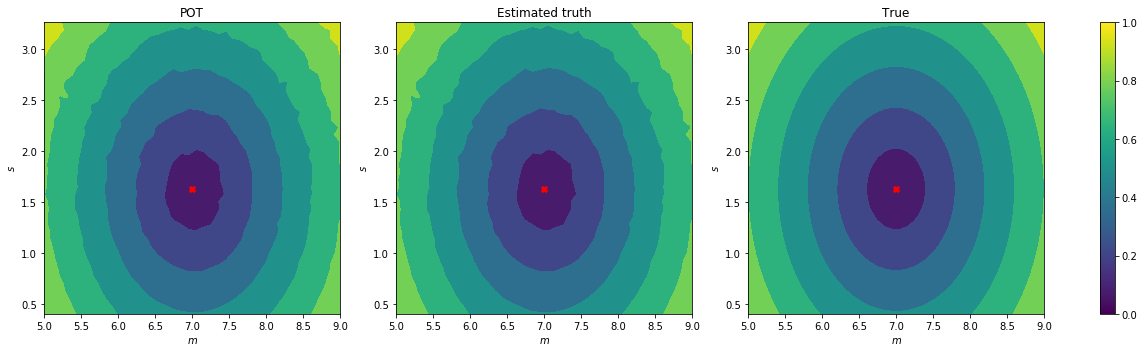

In [7]:
M, S = np.meshgrid(m_range, s_range,indexing='ij')
plt.rcParams['figure.figsize'] = (16,5)
fig, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[4,4,4,0.2]))
axs[0].contourf(M, S, W)
axs[0].scatter([m_0],[s_0],marker='X',c='red')
axs[0].set_xlabel('$m$')
axs[0].set_ylabel('$s$')
axs[0].set_title('POT')

axs[1].contourf(M, S, W_est)
axs[1].scatter([m_0],[s_0],marker='X',c='red')
axs[1].set_xlabel('$m$')
axs[1].set_ylabel('$s$')
axs[1].set_title('Estimated truth')

axs[2].contourf(M, S, W_0)
axs[2].scatter([m_0],[s_0],marker='X',c='red')
axs[2].set_xlabel('$m$')
axs[2].set_ylabel('$s$')
axs[2].set_title('True')
fig.colorbar(axs[np.argmax([W.max(), W_est.max(),W_0.max()])].collections[0], cax=axs[3])
plt.tight_layout()
plt.show()